<h1>CNN model za prepoznavanje šalica</h1>
<hr/>
<h2>Iteracija Foxtrot</h2>
<p>Testovi sa smanjenom kompleksnosti modela</p>
<p> Set slika je 700/100, Dropot-a i Data Augmentation i regularizacija</p>

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

import matplotlib.pyplot as plt
import numpy as np

<p>Postavljanje direktorija sa trening i validacijskim slikama:</p>

In [3]:
# Postavi direktorije slika
train_dir = "../../Projekt_slike_128/Trening"
test_dir = "../../Projekt_slike_128/Validacija"

<h3> Funkcija za određivanje broja epoha, veličinu batcheva i generiranje podataka</h3>

In [4]:
def generate_epochs_batchs_data():
    """ određivanje i priprema podataka """
    # Odredi broj epoha i veličinu batcheva
    num_of_epochs = input("Number of epochs:")
    num_of_epochs = int(num_of_epochs)
    size_of_batch = input("Batch size:")
    size_of_batch = int(size_of_batch)
    # Generator podataka sa augmentacijom za trening
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )
    return(train_generator,test_generator, num_of_epochs, size_of_batch)

In [5]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 2
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


<h3>Funkcija za plotanje rezultata </h3>

In [6]:
def plots_and_evaluation(history):
    """ funkcija za plotanje točnosti i gubitka  """
    # Plot trening i valuacija - točnost
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot trening i validacija - gubitak
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()



<p>Prikaz random primjera slika:</p>

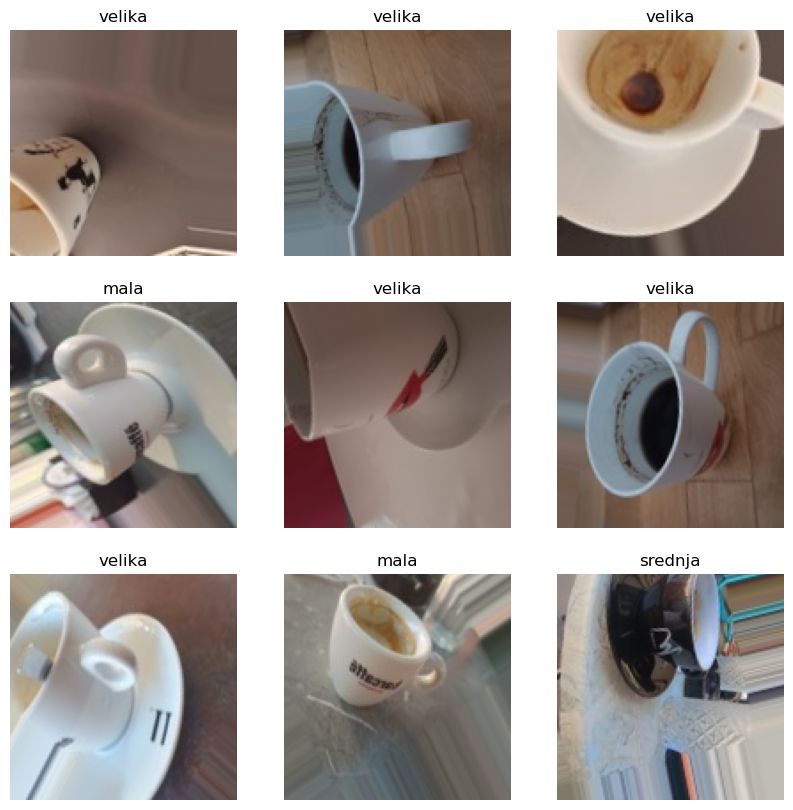

In [7]:
# Primjeri slika
def display_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        
        if (np.argmax(y[i])==0):
            plt.title("mala")
        if (np.argmax(y[i])==1):
            plt.title("srednja")
        if (np.argmax(y[i])==2):
            plt.title("velika")
        plt.axis("off")
    plt.show()


display_sample_images(train_generator)

<hr/>

<h2> Iteracija F.1</h2>
<p>dodana L2 regularizacija i padding="same"</p>
<p> broj parametara povećan na preko 4 000 000</p>

In [13]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        Dropout(0.5),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 16)       

<h4>Kompajliranje i trening</h4>
<p>epohe: 20</p>
<p>batch size: 64</p>
<hr/>

In [15]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [16]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/20


2024-08-18 16:01:33.308509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 838ms/step - loss: 1.0465 - accuracy: 0.4705 - val_loss: 1.3044 - val_accuracy: 0.1016
Epoch 2/20
32/32 [==============================] - 28s 875ms/step - loss: 1.0003 - accuracy: 0.5020 - val_loss: 1.2286 - val_accuracy: 0.2305
Epoch 3/20
32/32 [==============================] - 28s 869ms/step - loss: 0.9963 - accuracy: 0.4966 - val_loss: 1.2575 - val_accuracy: 0.2852
Epoch 4/20
32/32 [==============================] - 28s 868ms/step - loss: 0.9198 - accuracy: 0.5629 - val_loss: 1.2590 - val_accuracy: 0.2969
Epoch 5/20
32/32 [==============================] - 28s 872ms/step - loss: 0.9099 - accuracy: 0.5904 - val_loss: 1.3212 - val_accuracy: 0.1914
Epoch 6/20
32/32 [==============================] - 29s 887ms/step - loss: 0.8359 - accuracy: 0.6326 - val_loss: 1.3830 - val_accuracy: 0.2227
Epoch 7/20
32/32 [==============================] - 29s 882ms/step - loss: 0.7911 - accuracy: 0.6547 - val_loss: 1.5831 - val_accuracy: 0.2422
Epoch 8/20

<hr/>
<h3>Plotovi točnosti i gubitka za trening i validaciju</h3>
<p>i evaluacija</p>

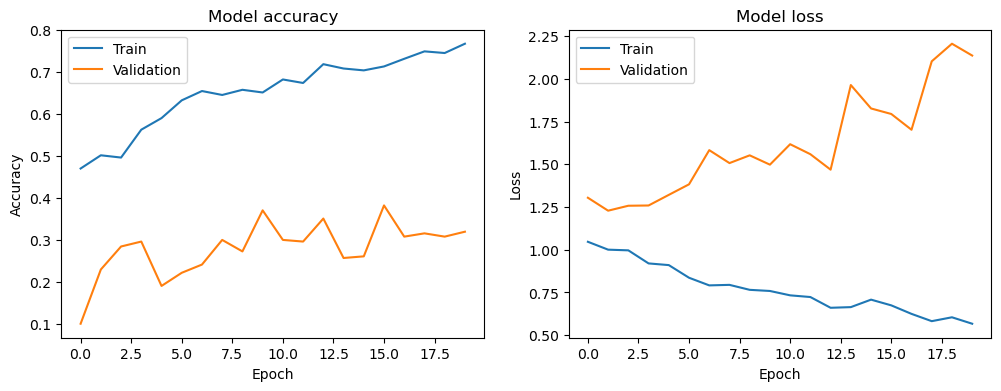

4/4 [==============================] - 1s 136ms/step - loss: 2.0008 - accuracy: 0.3242
Test accuracy: 0.32421875


In [18]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<hr/>
<h2> Iteracija F.2</h2>
<p>dodana L2 - prvi dense layer smanje na 256 , broj parametara na 2 100 000</p>

In [9]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        Dropout(0.5),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 16)       

<h4>Trening i kompajliranje modela</h4>
<p>epochs: 20</p>
<p>batch size: 64</p>

In [11]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [12]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/20


2024-08-18 16:33:00.600093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 837ms/step - loss: 1.0257 - accuracy: 0.4917 - val_loss: 1.4302 - val_accuracy: 0.2578
Epoch 2/20
32/32 [==============================] - 28s 857ms/step - loss: 0.9262 - accuracy: 0.5702 - val_loss: 1.4531 - val_accuracy: 0.2656
Epoch 3/20
32/32 [==============================] - 28s 874ms/step - loss: 0.8637 - accuracy: 0.6267 - val_loss: 1.5944 - val_accuracy: 0.2656
Epoch 4/20
32/32 [==============================] - 28s 875ms/step - loss: 0.8683 - accuracy: 0.6125 - val_loss: 1.6423 - val_accuracy: 0.2734
Epoch 5/20
32/32 [==============================] - 28s 863ms/step - loss: 0.8224 - accuracy: 0.6356 - val_loss: 1.6451 - val_accuracy: 0.2617
Epoch 6/20
32/32 [==============================] - 28s 864ms/step - loss: 0.8121 - accuracy: 0.6473 - val_loss: 1.5494 - val_accuracy: 0.2969
Epoch 7/20
32/32 [==============================] - 28s 863ms/step - loss: 0.7702 - accuracy: 0.6753 - val_loss: 1.6378 - val_accuracy: 0.2891
Epoch 8/20

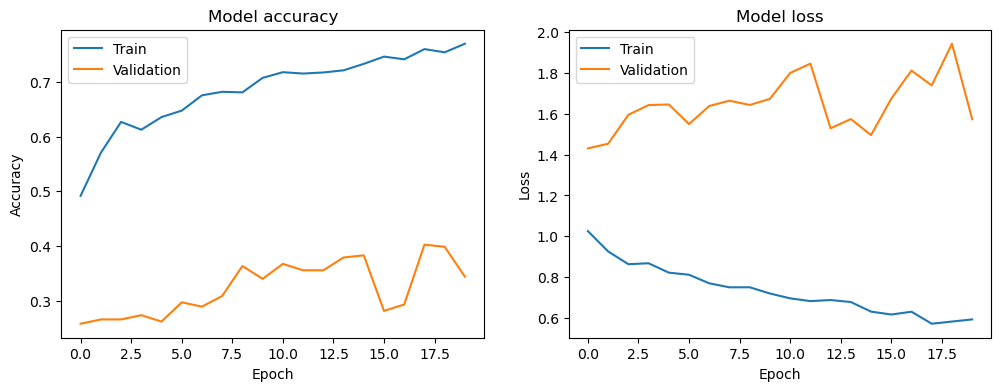

4/4 [==============================] - 1s 124ms/step - loss: 1.5466 - accuracy: 0.3594
Test accuracy: 0.359375


In [13]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.3</h2>
<p> ponavljanje modela F.2 na 50 epoha</p>

<h4>Trening i kompajliranje modela</h4>
<p>epochs: 50</p>
<p>batch size: 64</p>

In [14]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 50
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 16)       

In [16]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/50


2024-08-18 16:45:48.247730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 35s 877ms/step - loss: 0.6187 - accuracy: 0.7505 - val_loss: 1.4774 - val_accuracy: 0.3828
Epoch 2/50
32/32 [==============================] - 29s 907ms/step - loss: 0.5481 - accuracy: 0.7721 - val_loss: 1.4963 - val_accuracy: 0.3828
Epoch 3/50
32/32 [==============================] - 29s 890ms/step - loss: 0.5598 - accuracy: 0.7716 - val_loss: 1.4965 - val_accuracy: 0.3828
Epoch 4/50
32/32 [==============================] - 29s 889ms/step - loss: 0.5649 - accuracy: 0.7765 - val_loss: 1.4565 - val_accuracy: 0.4375
Epoch 5/50
32/32 [==============================] - 28s 881ms/step - loss: 0.5080 - accuracy: 0.7986 - val_loss: 1.5030 - val_accuracy: 0.3906
Epoch 6/50
32/32 [==============================] - 29s 889ms/step - loss: 0.5132 - accuracy: 0.7908 - val_loss: 1.5133 - val_accuracy: 0.3555
Epoch 7/50
32/32 [==============================] - 29s 892ms/step - loss: 0.5334 - accuracy: 0.7883 - val_loss: 1.5518 - val_accuracy: 0.3398
Epoch 8/50

<hr/>
<h4>Pltovi i evaluacija:</h4>

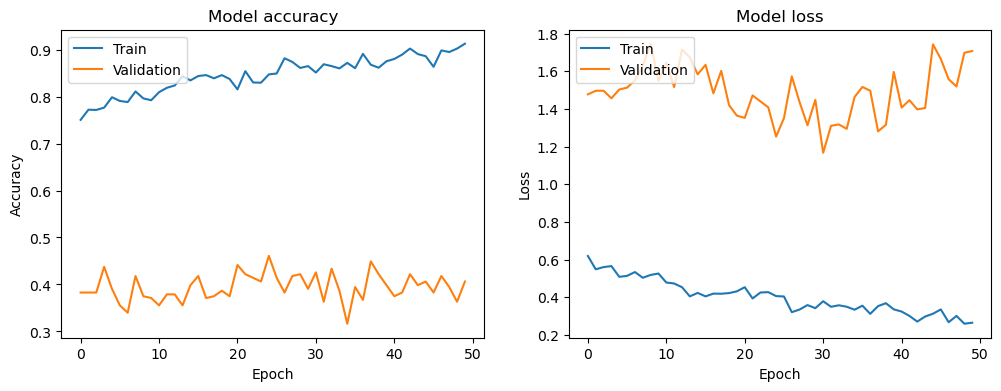

4/4 [==============================] - 1s 126ms/step - loss: 1.7735 - accuracy: 0.3906
Test accuracy: 0.390625


In [17]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.4</h2>
<p> dodavanje Conv sloja - broj parametara smanjen na 100 000 , 20 epoha</p>

In [18]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        Dropout(0.5),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        Dropout(0.5),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 16)       

<h4>Trening i kompajliranje</h4>
<p>epohe : 20</p>
<p> batch size: 64 </p>

In [19]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [20]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/20


2024-08-18 18:32:54.955973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 37s 913ms/step - loss: 1.2019 - accuracy: 0.3517 - val_loss: 1.1686 - val_accuracy: 0.3242
Epoch 2/20
32/32 [==============================] - 30s 922ms/step - loss: 1.1218 - accuracy: 0.3955 - val_loss: 1.2607 - val_accuracy: 0.1367
Epoch 3/20
32/32 [==============================] - 30s 930ms/step - loss: 1.0740 - accuracy: 0.4651 - val_loss: 1.3376 - val_accuracy: 0.3320
Epoch 4/20
32/32 [==============================] - 29s 909ms/step - loss: 1.0441 - accuracy: 0.4917 - val_loss: 1.2471 - val_accuracy: 0.0078
Epoch 5/20
32/32 [==============================] - 29s 909ms/step - loss: 0.9916 - accuracy: 0.5344 - val_loss: 1.3803 - val_accuracy: 0.2812
Epoch 6/20
32/32 [==============================] - 29s 893ms/step - loss: 0.9210 - accuracy: 0.5771 - val_loss: 1.4649 - val_accuracy: 0.2930
Epoch 7/20
32/32 [==============================] - 29s 896ms/step - loss: 0.8986 - accuracy: 0.5899 - val_loss: 1.7068 - val_accuracy: 0.1680
Epoch 8/20

<p>Plotovi i evaluacija</p>

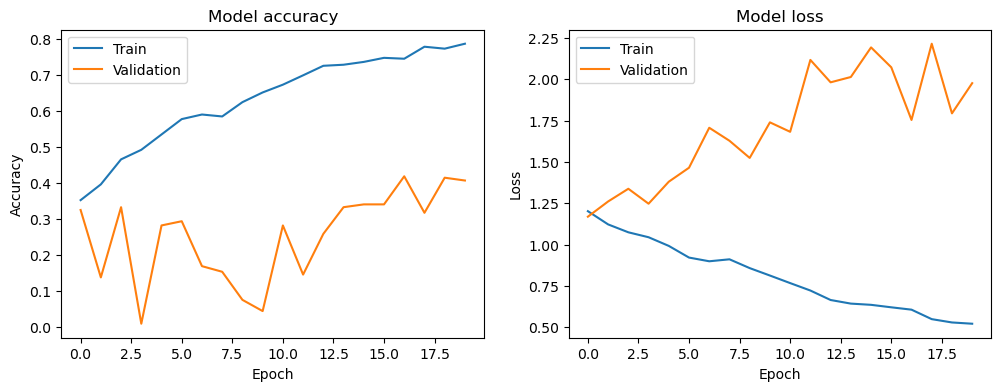

4/4 [==============================] - 1s 130ms/step - loss: 1.9726 - accuracy: 0.4297
Test accuracy: 0.4296875


In [21]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.5</h2>
<p> dodavanje Conv sloja - broj parametara smanjen na 100 000 , 50 epoha</p>

<h4>Trening i kompajliranje</h4>
<p>epohe : 50</p>
<p> batch size: 64 </p>

In [22]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 50
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/50


2024-08-18 18:45:52.643587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 35s 878ms/step - loss: 0.5716 - accuracy: 0.7750 - val_loss: 2.1792 - val_accuracy: 0.3750
Epoch 2/50
32/32 [==============================] - 29s 898ms/step - loss: 0.4820 - accuracy: 0.8070 - val_loss: 1.8999 - val_accuracy: 0.3789
Epoch 3/50
32/32 [==============================] - 29s 891ms/step - loss: 0.4697 - accuracy: 0.8104 - val_loss: 2.1524 - val_accuracy: 0.4180
Epoch 4/50
32/32 [==============================] - 28s 858ms/step - loss: 0.4497 - accuracy: 0.8291 - val_loss: 1.9290 - val_accuracy: 0.3789
Epoch 5/50
32/32 [==============================] - 28s 864ms/step - loss: 0.4418 - accuracy: 0.8315 - val_loss: 2.0360 - val_accuracy: 0.4336
Epoch 6/50
32/32 [==============================] - 28s 869ms/step - loss: 0.4331 - accuracy: 0.8374 - val_loss: 1.9496 - val_accuracy: 0.3828
Epoch 7/50
32/32 [==============================] - 28s 867ms/step - loss: 0.4254 - accuracy: 0.8340 - val_loss: 2.1591 - val_accuracy: 0.4062
Epoch 8/50

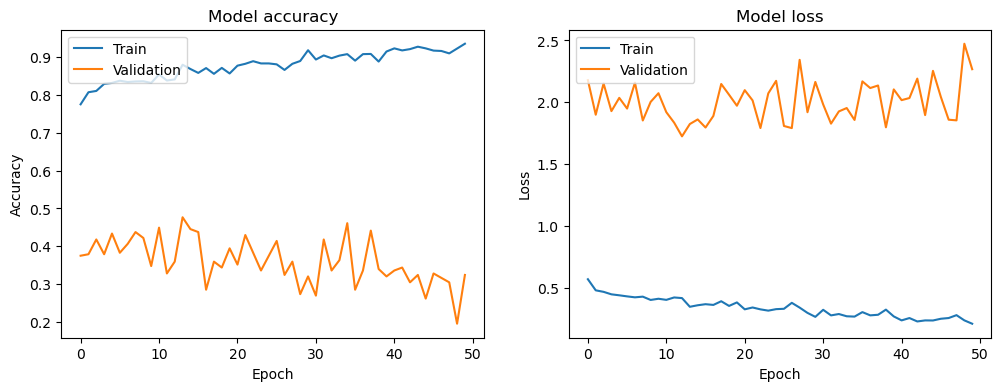

4/4 [==============================] - 1s 146ms/step - loss: 2.1392 - accuracy: 0.3281
Test accuracy: 0.328125


In [23]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.6</h2>
<p> smanjivanje dropouta na 0.4</p>

In [26]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        Dropout(0.4),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        Dropout(0.4),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64, 64, 8)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 32, 32, 16)       

In [27]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/20


2024-08-18 19:15:27.517182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 34s 841ms/step - loss: 1.2289 - accuracy: 0.3433 - val_loss: 1.1696 - val_accuracy: 0.4180
Epoch 2/20
32/32 [==============================] - 28s 865ms/step - loss: 1.1615 - accuracy: 0.3669 - val_loss: 1.1652 - val_accuracy: 0.3477
Epoch 3/20
32/32 [==============================] - 28s 864ms/step - loss: 1.1442 - accuracy: 0.4121 - val_loss: 1.1653 - val_accuracy: 0.3555
Epoch 4/20
32/32 [==============================] - 28s 868ms/step - loss: 1.0922 - accuracy: 0.4646 - val_loss: 1.1762 - val_accuracy: 0.3359
Epoch 5/20
32/32 [==============================] - 28s 867ms/step - loss: 1.0560 - accuracy: 0.4936 - val_loss: 1.1815 - val_accuracy: 0.3242
Epoch 6/20
32/32 [==============================] - 28s 854ms/step - loss: 0.9730 - accuracy: 0.5850 - val_loss: 1.3487 - val_accuracy: 0.3125
Epoch 7/20
32/32 [==============================] - 28s 858ms/step - loss: 0.9376 - accuracy: 0.5801 - val_loss: 1.3622 - val_accuracy: 0.3477
Epoch 8/20

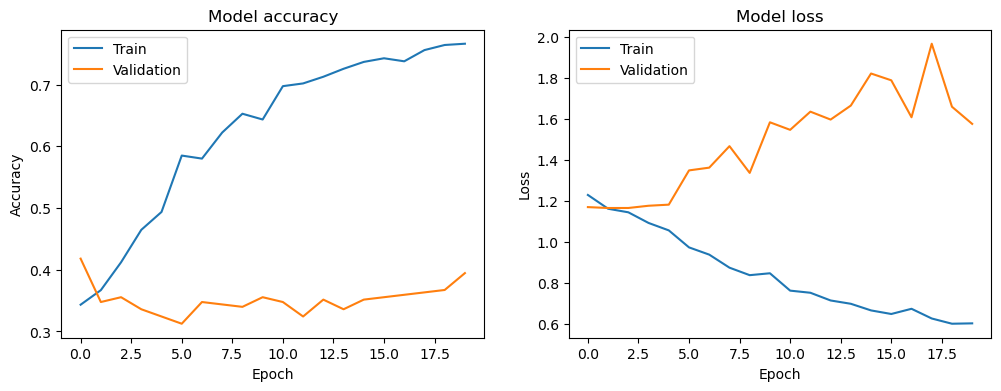

4/4 [==============================] - 1s 145ms/step - loss: 1.7894 - accuracy: 0.3984
Test accuracy: 0.3984375


In [28]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.7</h2>
<p> daljnje smanjivanje dropouta na 0.3</p>

In [30]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 64, 64, 8)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 32, 32, 16)       

In [31]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/20


2024-08-18 19:29:34.146410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_17/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 34s 848ms/step - loss: 1.1926 - accuracy: 0.3364 - val_loss: 1.1648 - val_accuracy: 0.3203
Epoch 2/20
32/32 [==============================] - 28s 869ms/step - loss: 1.1552 - accuracy: 0.3787 - val_loss: 1.1550 - val_accuracy: 0.3398
Epoch 3/20
32/32 [==============================] - 28s 866ms/step - loss: 1.1399 - accuracy: 0.3900 - val_loss: 1.1492 - val_accuracy: 0.3398
Epoch 4/20
32/32 [==============================] - 28s 860ms/step - loss: 1.0987 - accuracy: 0.4376 - val_loss: 1.2301 - val_accuracy: 0.3789
Epoch 5/20
32/32 [==============================] - 28s 870ms/step - loss: 1.1248 - accuracy: 0.4194 - val_loss: 1.1569 - val_accuracy: 0.3164
Epoch 6/20
32/32 [==============================] - 28s 868ms/step - loss: 1.0770 - accuracy: 0.4754 - val_loss: 1.2018 - val_accuracy: 0.4688
Epoch 7/20
32/32 [==============================] - 28s 870ms/step - loss: 0.9878 - accuracy: 0.5378 - val_loss: 1.5108 - val_accuracy: 0.3320
Epoch 8/20

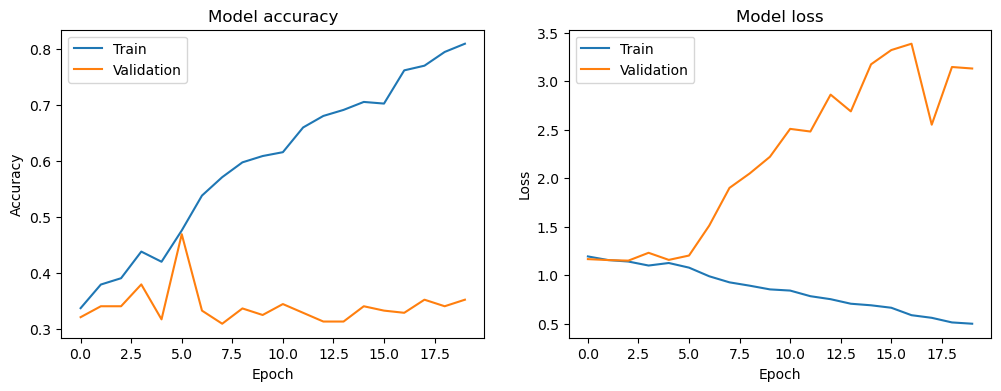

4/4 [==============================] - 1s 150ms/step - loss: 3.3073 - accuracy: 0.3320
Test accuracy: 0.33203125


In [32]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.8</h2>
<p> Dropout  0.3, Dense vraćen na 512, drugi Dense(128) skinut - parametri dignuti na 2 000 000</p>

In [34]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(512, activation="relu"),
       
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 64, 64, 8)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 16)       

In [35]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/20


2024-08-18 19:42:42.772569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 846ms/step - loss: 1.3192 - accuracy: 0.3423 - val_loss: 1.1717 - val_accuracy: 0.3359
Epoch 2/20
32/32 [==============================] - 28s 872ms/step - loss: 1.1688 - accuracy: 0.3551 - val_loss: 1.1666 - val_accuracy: 0.3516
Epoch 3/20
32/32 [==============================] - 28s 870ms/step - loss: 1.1633 - accuracy: 0.3613 - val_loss: 1.1627 - val_accuracy: 0.3398
Epoch 4/20
32/32 [==============================] - 28s 861ms/step - loss: 1.1568 - accuracy: 0.3576 - val_loss: 1.1646 - val_accuracy: 0.3320
Epoch 5/20
32/32 [==============================] - 28s 873ms/step - loss: 1.1004 - accuracy: 0.4253 - val_loss: 1.7150 - val_accuracy: 0.1133
Epoch 6/20
32/32 [==============================] - 28s 872ms/step - loss: 1.0596 - accuracy: 0.4715 - val_loss: 1.9594 - val_accuracy: 0.1562
Epoch 7/20
32/32 [==============================] - 28s 863ms/step - loss: 1.0237 - accuracy: 0.4966 - val_loss: 1.8747 - val_accuracy: 0.0859
Epoch 8/20

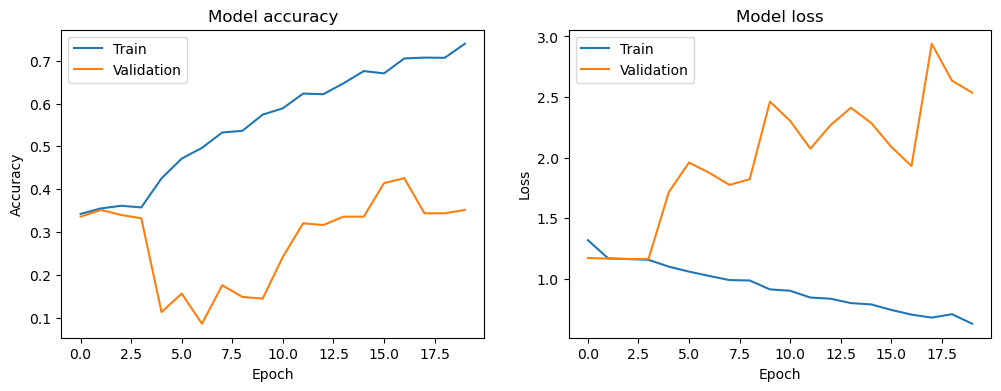

4/4 [==============================] - 1s 119ms/step - loss: 2.6235 - accuracy: 0.3828
Test accuracy: 0.3828125


In [36]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.8</h2>

<p>Dropout 0.3, Dense vraćen na 512, drugi Dense(128) skinut - parametri dignuti na 2 000 000 epohe:50 </p>

In [37]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 50
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/50


2024-08-18 20:00:02.238865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 846ms/step - loss: 0.6146 - accuracy: 0.7412 - val_loss: 3.2930 - val_accuracy: 0.3359
Epoch 2/50
32/32 [==============================] - 28s 862ms/step - loss: 0.5644 - accuracy: 0.7706 - val_loss: 3.1814 - val_accuracy: 0.3203
Epoch 3/50
32/32 [==============================] - 28s 869ms/step - loss: 0.5579 - accuracy: 0.7647 - val_loss: 3.3680 - val_accuracy: 0.3906
Epoch 4/50
32/32 [==============================] - 28s 868ms/step - loss: 0.5221 - accuracy: 0.7868 - val_loss: 2.9535 - val_accuracy: 0.3359
Epoch 5/50
32/32 [==============================] - 28s 868ms/step - loss: 0.5258 - accuracy: 0.7942 - val_loss: 2.8556 - val_accuracy: 0.3516
Epoch 6/50
32/32 [==============================] - 28s 873ms/step - loss: 0.4852 - accuracy: 0.8129 - val_loss: 2.8064 - val_accuracy: 0.3750
Epoch 7/50
32/32 [==============================] - 28s 869ms/step - loss: 0.4739 - accuracy: 0.8197 - val_loss: 2.6981 - val_accuracy: 0.3867
Epoch 8/50

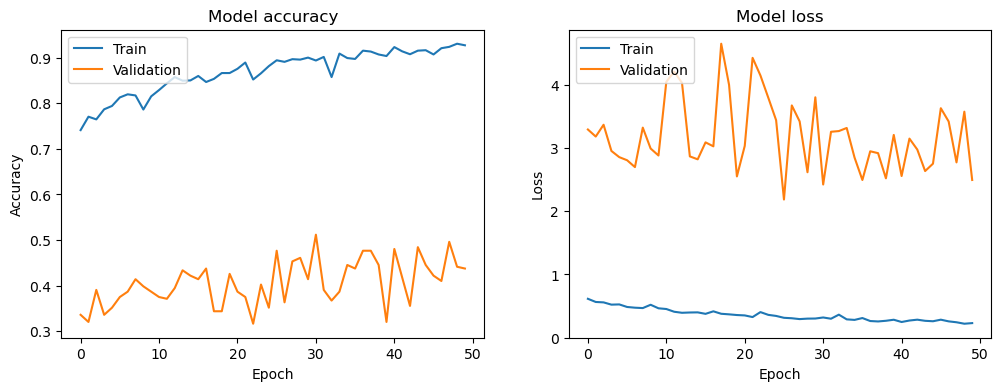

4/4 [==============================] - 1s 135ms/step - loss: 2.4855 - accuracy: 0.4492
Test accuracy: 0.44921875


In [38]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.9</h2>

<p>na dva sloja Dropout 0.2,  - parametri  na 2 000 000 epohe:20 </p>

In [42]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same",input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(16, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(32, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), padding="same",activation="relu", kernel_regularizer=l2(0.001)
),
        
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(512, activation="relu"),
       
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 64, 64, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 64, 64, 8)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 32, 32, 16)       

In [40]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 20
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/20


2024-08-18 20:27:06.225238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 845ms/step - loss: 1.2541 - accuracy: 0.3458 - val_loss: 1.1638 - val_accuracy: 0.3438
Epoch 2/20
32/32 [==============================] - 28s 859ms/step - loss: 1.1570 - accuracy: 0.3630 - val_loss: 1.1562 - val_accuracy: 0.3203
Epoch 3/20
32/32 [==============================] - 28s 867ms/step - loss: 1.1444 - accuracy: 0.3831 - val_loss: 1.1503 - val_accuracy: 0.3242
Epoch 4/20
32/32 [==============================] - 28s 863ms/step - loss: 1.1105 - accuracy: 0.4018 - val_loss: 1.2551 - val_accuracy: 0.2188
Epoch 5/20
32/32 [==============================] - 28s 862ms/step - loss: 1.0451 - accuracy: 0.4735 - val_loss: 1.8162 - val_accuracy: 0.4570
Epoch 6/20
32/32 [==============================] - 28s 858ms/step - loss: 1.0418 - accuracy: 0.4843 - val_loss: 1.6285 - val_accuracy: 0.2969
Epoch 7/20
32/32 [==============================] - 28s 870ms/step - loss: 0.9956 - accuracy: 0.5192 - val_loss: 1.8744 - val_accuracy: 0.3086
Epoch 8/20

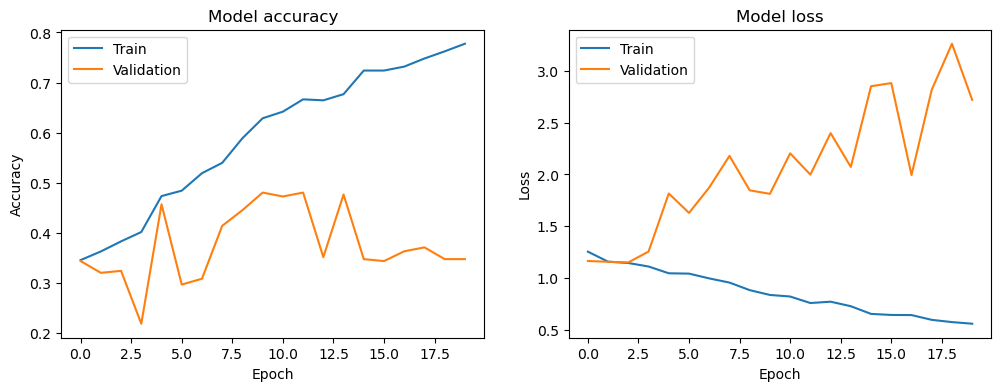

4/4 [==============================] - 1s 148ms/step - loss: 2.6105 - accuracy: 0.3633
Test accuracy: 0.36328125


In [41]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2>Iteracija F.10</h2>

<p>na dva sloja Dropout 0.2,  - parametri  na 2 000 000 epohe:50 </p>

In [46]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Number of epochs: 50
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/50


2024-08-18 21:04:11.821655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 844ms/step - loss: 0.2877 - accuracy: 0.9037 - val_loss: 4.8472 - val_accuracy: 0.3633
Epoch 2/50
32/32 [==============================] - 28s 875ms/step - loss: 0.2496 - accuracy: 0.9194 - val_loss: 5.8250 - val_accuracy: 0.3438
Epoch 3/50
32/32 [==============================] - 28s 871ms/step - loss: 0.2672 - accuracy: 0.9140 - val_loss: 3.9850 - val_accuracy: 0.3203
Epoch 4/50
32/32 [==============================] - 28s 864ms/step - loss: 0.2568 - accuracy: 0.9185 - val_loss: 5.3022 - val_accuracy: 0.4375
Epoch 5/50
32/32 [==============================] - 28s 860ms/step - loss: 0.2305 - accuracy: 0.9288 - val_loss: 5.5722 - val_accuracy: 0.3516
Epoch 6/50
32/32 [==============================] - 28s 867ms/step - loss: 0.2526 - accuracy: 0.9234 - val_loss: 5.6830 - val_accuracy: 0.3203
Epoch 7/50
32/32 [==============================] - 28s 870ms/step - loss: 0.2259 - accuracy: 0.9194 - val_loss: 6.0230 - val_accuracy: 0.3555
Epoch 8/50

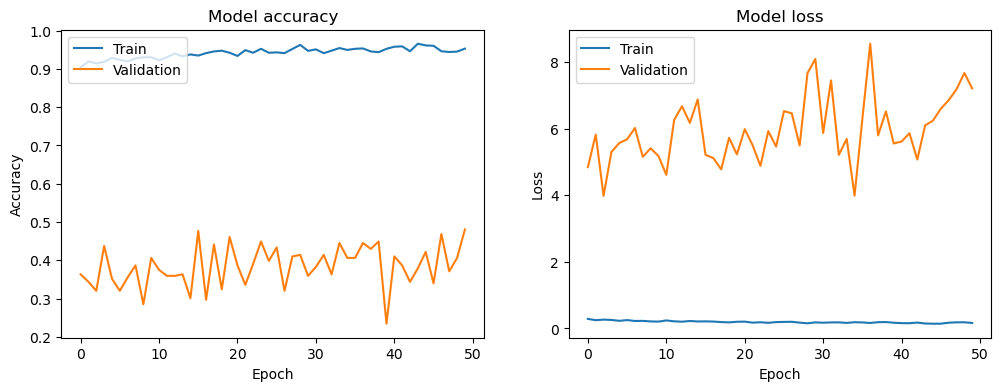

4/4 [==============================] - 1s 126ms/step - loss: 7.2904 - accuracy: 0.4883
Test accuracy: 0.48828125


In [47]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h3>Zaključak:</h3>
<p> Daljnje pojednostavljivanje modela sa dodanom l2 regularizacijom nije donijelo željene rezultate</p>
<p>smanjivanje dropouta pridonijelo je povećanju gubitka validacijskog seta</p>
<p>smanjivanjem parametara poterbno je povečati broj epoha sa nešto bolje rezultate</p>
<p>Daljnji koraci:</p>
<p>DOdati regularizaciju na najuspješniji Echo model</p>